In [167]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import scipy as sp
import scienceplots
import matplotlib.pyplot as plt
plt.style.use('science')

In [168]:
lamda_0 = 589 * u.nm
kb = const.k_B
kr = 0.3 * (u.cm)**2 / u.g
GM = const.GM_sun
R = const.R_sun
a0 = const.a0
T = 5800 * u.K
pi = np.pi

In [169]:
ratio = (lamda_0 / (kb*T)) * (2 / 3 / kr) * (GM / (R**2)) * (4 * np.pi * a0**2) * np.sqrt(23)

In [170]:
ratio.decompose()

<Quantity 0.00756372>

In [29]:
def H_integrand(x , u , a):
    return a * np.exp(-x**2) / ((u - x)**2 + a**2)

In [51]:
u = np.linspace(-4,4,1000)
a_val = 0.1
H_u_a = np.zeros(len(u))

for i in range(len(u)):
    integral = sp.integrate.quad(H_integrand , a = -1000, b = 1000, args = (u[i], a_val))[0]
    H_u_a[i] = integral / pi

y = H_u_a / np.sqrt(pi)

In [52]:
def y_dop(u):
    return (1 / (np.sqrt(pi))) * np.exp(-u**2)

def y_pre(u , a = 0.1):
    return a / pi / (u**2 + a**2)

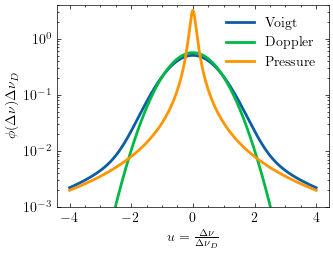

In [54]:
plt.plot(u,y,lw = 2, label = 'Voigt')
plt.plot(u,y_dop(u),lw = 2, label = 'Doppler')
plt.plot(u,y_pre(u),lw = 2, label = 'Pressure')
plt.ylim((1e-3,4))
plt.yscale('log')
plt.xlabel(r'$u = \frac{\Delta \nu}{\Delta \nu_D}$')
plt.ylabel(r'$\phi (\Delta \nu) \Delta \nu_D$')
plt.legend()
plt.savefig('hw6_Q3C.pdf', dpi = 300)

In [86]:
def tau_nu_doppler(u,tau_0):
    return tau_0 * np.exp(-u**2)

a = 0.3
H_0_a = sp.integrate.quad(H_integrand , a = -1000, b = 1000, args = (0, a))[0]

def tau_nu_voigt(u,tau_0,a):
    H_u_a = sp.integrate.quad(H_integrand , a = -1000, b = 1000, args = (u, a))[0]
    return tau_0 * H_u_a / H_0_a

In [90]:
# Precompute H_0_a (since it's independent of u, this is a constant)
a = 0.3
H_0_a = sp.integrate.quad(H_integrand, -1000, 1000, args=(0, a))[0]

# Vectorized function
def H_u_a(u, a):
    # Use numpy's vectorize to apply quad for each value of u
    return np.array([sp.integrate.quad(H_integrand, -1000, 1000, args=(ui, a))[0] for ui in u])

def tau_nu_voigt(u_array, tau_0, a):
    # H_u_a is now computed for all u in u_array
    H_u_a_values = H_u_a(u_array, a)
    
    # Return the array of tau_nu_voigt for each u
    return tau_0 * H_u_a_values / H_0_a


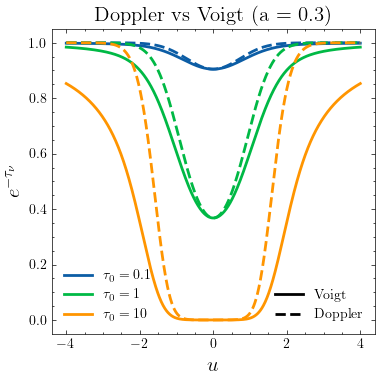

In [111]:
# Assuming tau_nu_doppler and tau_nu_voigt functions are already defined

# Parameters
u = np.linspace(-4, 4, 1000)
a = 0.3
tau = [0.1, 1, 10]

lw = 2
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.set_tight_layout(True)

voigt_lines = []  # To store Voigt lines for the second legend

# Plotting Doppler and Voigt curves
for i, t in enumerate(tau):
    # Plot Doppler (dashed line)
    ax.plot(u, np.exp(-tau_nu_doppler(u, t)), lw=lw, color=f'C{i}', linestyle='dashed')
    # Plot Voigt (solid line)
    voigt_line, = ax.plot(u, np.exp(-tau_nu_voigt(u, t, a)), lw=lw, color=f'C{i}')
    voigt_lines.append(voigt_line)  # Store the Voigt line for the second legend

# Title and labels
ax.set_title('Doppler vs Voigt (a = 0.3)', fontsize = 15)
ax.set_ylabel(r'$e^{-\tau_{\nu}}$', fontsize = 15)
ax.set_xlabel(r'$u$', fontsize = 15)

# Create custom legends
# 1. Black legend for Doppler (dashed) and Voigt (solid)
custom_lines = [
    plt.Line2D([0], [0], color='black', lw=lw, linestyle='solid', label='Voigt'),
    plt.Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label='Doppler')
]
legend1 = ax.legend(handles=custom_lines, loc='lower right', frameon=False)

# 2. Legend for tau values, only using Voigt lines (no title)
legend2 = ax.legend(handles=voigt_lines, labels=[f'$\\tau_0 = {t}$' for t in tau], loc='lower left', frameon=False)

# Add both legends to the plot
ax.add_artist(legend1)

# Save the figure
plt.savefig('hw6_Q3d.pdf', dpi=300)
plt.show()


In [158]:
from scipy.special import erfc

# Define the integrand for EW (1 - e^-tau_nu_doppler)
def EW_doppler_integrand(u, tau_0):
    return 1 - np.exp(-tau_nu_doppler(u, tau_0))

# Function to calculate EW for a given tau_0
def calculate_EW_doppler(tau_0):
    # Integrate from -inf to inf
    result, _ = sp.integrate.quad(EW_doppler_integrand, 0, np.inf, args=(tau_0))
    return 2 * result

# Define the pressure broadening integrand function
def EW_pressure_integrand(y, tau_0):
    return 1 - np.exp(- tau_0 / (1 + y**2))

# Function to calculate EW_P for a given tau_0
def calculate_EW_pressure(tau_0):
    # Integrate from -inf to inf
    result, _ = sp.integrate.quad(EW_pressure_integrand, 0, np.inf, args=(tau_0))
    return 2 * result / np.sqrt(pi)

def H_integrand(x , u , a):
    return (1 / pi) * a * np.exp(-x**2) / ((u - x)**2 + a**2)

# H(0, a) for Voigt profile as exp(a^2) * erfc(a)
def H_0_a(a):
    return np.exp(a**2) * erfc(a)

def H_u_a(u, a):
    return sp.integrate.quad(H_integrand, -np.inf, np.inf, args=(u, a))[0]

# Compute the tau_nu_voigt for each u and tau_0
def tau_nu_voigt(u, tau_0, a, H0a):
    return tau_0 * H_u_a(u,a) / H0a  # Placeholder (replace with actual Voigt function)

# Integral for EW based on tau_nu_voigt
def EW_voigt_integrand(u, tau_0, a, H0a):
    return 1 - np.exp(-tau_nu_voigt(u, tau_0, a, H0a))

# Function to calculate the integral EW for a given tau_0 and a
def calculate_EW_voigt(tau_0, a, H0a):
    # Integral over u from -inf to inf
    result, _ = sp.integrate.quad(EW_voigt_integrand, -np.inf, np.inf, args=(tau_0, a, H0a))
    return result

# Range of tau_0 values (logarithmically spaced for better visualization)
tau_0_values = np.logspace(-2, 3, 10)  # From 0.01 to 1000

# Compute EW for each tau_0 value
EW_values_doppler = [calculate_EW_doppler(tau_0) for tau_0 in tau_0_values]
EW_values_pressure = [calculate_EW_pressure(tau_0) for tau_0 in tau_0_values]

# Values of 'a'
a_values = [0.01, 0.1, 1]

EW_values_voigt = np.zeros((len(tau_0_values),3))

# Loop over the different a values
for i,a in enumerate(a_values):
    # Compute H_0(a)
    H0a = H_0_a(a)
    
    # Compute the equivalent width for each tau_0
    EW_values_voigt[:,i] = [H0a * calculate_EW_voigt(tau_0, a, H0a) for tau_0 in tau_0_values]


/var/folders/nm/fjbhgywj517888nl37r_j1jm0000gn/T/ipykernel_80798/3472155578.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = sp.integrate.quad(EW_voigt_integrand, -np.inf, np.inf, args=(tau_0, a, H0a))


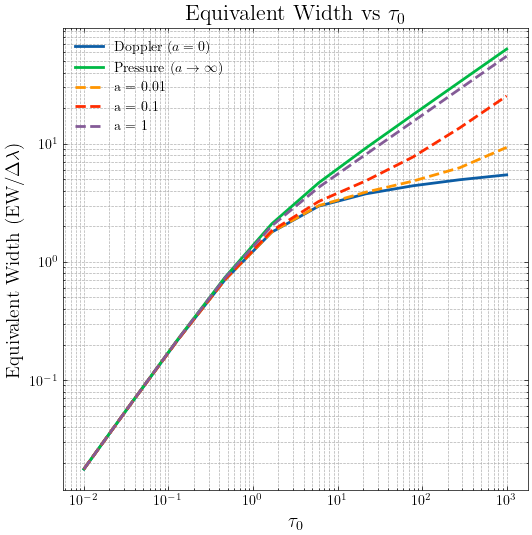

In [165]:
# Plotting
plt.figure(figsize=(6, 6))

plt.plot(tau_0_values, EW_values_doppler, lw=2, color='C0', label = r'Doppler $(a = 0)$')
plt.plot(tau_0_values, EW_values_pressure, lw=2, color='C1', label = r'Pressure $(a \rightarrow \infty) $')

for i,a in enumerate(a_values):
    # Plot the results
    plt.plot(tau_0_values, EW_values_voigt[:,i], lw=2, label=f'a = {a}', color = f'C{i+2}', linestyle = 'dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau_0$', fontsize=14)
plt.ylabel('Equivalent Width (EW$/\Delta \lambda$)', fontsize=14)
plt.title('Equivalent Width vs $\\tau_0$', fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend()
# Save the figure
plt.savefig('Hw6_Q3e.pdf', dpi=300)
plt.show()